In [2]:
from __future__ import division, print_function

import netCDF4 as nc
import numpy as np
import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import glob
from geopy.distance import vincenty
from exceptions import KeyError
import gsw
import scipy.stats as scstat
%matplotlib inline

In [3]:
mesh = nc.Dataset('/mnt/storage0/jacquielee/research/data/Jasper/mesh_mask_anha4_201509.nc')

In [4]:
mask = mesh.variables['tmask'][0,:,:,:]

In [5]:
coordhgr = nc.Dataset('/mnt/storage0/xhu/ANHA4-I/ANHA4_mesh_hgr.nc')
coordzgr = nc.Dataset('/mnt/storage0/xhu/ANHA4-I/ANHA4_mesh_zgr.nc')
mesh = nc.Dataset('/mnt/storage0/xhu/ANHA4-I/mesh_mask_anha4_201509.nc')
grid = nc.Dataset('/mnt/storage0/xhu/ANHA4-I/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')

In [6]:
e1v = mesh.variables['e1v'][0,:,:]
e3v = mesh.variables['e3v'][0,:,:,:]
e2u = mesh.variables['e2u'][0,:,:]
e3u = mesh.variables['e3u'][0,:,:,:]
e1t= mesh.variables['e1t'][0,:,:]  # dx
e2t= mesh.variables['e2t'][0,:,:]  # dy 
e3t= mesh.variables['e3t'][0,:,:,:]
tmask= mesh.variables['tmask'][0,:,:,:]
umask= mesh.variables['umask'][0,:,:,:]
dep = mesh.variables['gdept_0'][0,:]

In [7]:
if umask.all() == tmask.all():
    print('True')

True


In [8]:
H = coordzgr.variables['nav_lev']
bathy = grid.variables['Bathymetry'][:]
lat = np.array(grid.variables['nav_lat'])
lon = np.array(grid.variables['nav_lon'])
bathy = ma.masked_values(bathy[:],0)

In [9]:
control = '/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_'
stlandj = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT002/ANHA4-VJT002_'
polzin  = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT003/ANHA4-VJT003_'
control_storage = '/mnt/storage0/jacquielee/research/data/ANHA4-EXH005/ANHA4-EXH005_'

In [10]:
year = '2011'
month = '01'
day = '05'

In [11]:
cgridW = nc.Dataset(control+'y'+year+'m'+month+'d'+day+'_gridW.nc')
zlevels = cgridW.variables['depthw']
nav_lon=cgridW.variables['nav_lon'][:]
nav_lat=cgridW.variables['nav_lat'][:]

In [12]:

kappa = ma.array(nc.Dataset(control_storage+'2012-2016avg_votkeavt.nc').variables['votkeavtfour'][:,:,:],mask=(mask-1)*-1)
kappa2 = ma.array(nc.Dataset(polzin+'2012-2016avg_votkeavt.nc').variables['votkeavtfour'][:,:,:],mask=(mask-1)*-1)
kappa3 = ma.array(nc.Dataset(stlandj+'2012-2016avg_votkeavt.nc').variables['votkeavtfour'][:,:,:],mask=(mask-1)*-1)

In [13]:
tidal2 = ma.array(nc.Dataset(polzin+'2012-2016avg_votkeavtidal.nc').variables['votkeavtidalfour'][:,:,:],mask=(mask-1)*-1)
tidal3 = ma.array(nc.Dataset(stlandj+'2012-2016avg_votkeavtidal.nc').variables['votkeavtidalfour'][:,:,:],mask=(mask-1)*-1)

In [14]:
ptidal_new = np.zeros_like(kappa)
sjtidal_new = np.zeros_like(kappa)


ptidal_new[49,:,:] = tidal2[49,:,:]
sjtidal_new[49,:,:] = tidal3[49,:,:]
#First interpolate onto t-grid
ptidal_new[0:-1,:,:] = (tidal2[0:-1,:,:]+tidal2[1:,:,:])/2
sjtidal_new[0:-1,:,:] = (tidal3[0:-1,:,:]+tidal3[1:,:,:])/2

In [15]:
ckappa_new = np.zeros_like(kappa)
pkappa_new = np.zeros_like(kappa)
sjkappa_new = np.zeros_like(kappa)

ckappa_new[49,:,:] = kappa[49,:,:]
pkappa_new[49,:,:] = kappa2[49,:,:]
sjkappa_new[49,:,:] = kappa3[49,:,:]
#First interpolate onto t-grid
ckappa_new[0:-1,:,:] = (kappa[0:-1,:,:]+kappa[1:,:,:])/2
pkappa_new[0:-1,:,:] = (kappa2[0:-1,:,:]+kappa2[1:,:,:])/2
sjkappa_new[0:-1,:,:] = (kappa3[0:-1,:,:]+kappa3[1:,:,:])/2


In [16]:
volume = ma.array(e1t*e2t*e3t,mask=(mask[:,:,:]-1)*-1)

In [17]:
volumeArctic = ma.array((volume[:,400:,:] / np.sum(volume[:,400:,:]))*100,mask=(mask[:,400:,:]-1)*-1)
volumeAtl = ma.array((volume[:,:400,:] / np.sum(volume[:,:400,:]))*100,mask=(mask[:,:400,:]-1)*-1)

In [18]:
#sum what proportion of the volume is less than 10**-14


def threshold(variable, weight,thresh, greaterthan = None, lessthan = None, equals=None):
    var = variable.flatten()
    wei = weight.flatten()
    
    percent = 0.0
    
    if greaterthan != None:
        for i in np.arange(0,len(var)-1):
            if var[i] > thresh and ma.is_masked(var[i]) == False:
                percent = percent+wei[i]
    elif lessthan != None:
        for i in np.arange(0,len(var)-1):
            if var[i] < thresh and ma.is_masked(var[i]) == False:
                percent = percent+wei[i]
    elif equals != None:
        for i in np.arange(0,len(var)-1):
            if var[i] == thresh and ma.is_masked(var[i]) == False:
                percent = percent+wei[i]
                
    print('complete')
    return percent


#zerop_per = threshold(pkappa_new[:,400:,:], volume2,0.0, equals=True)
# greatp_102 = threshold(pkappa_new[:,400:,:], volume2,10**-2, greaterthan=True)
# lessp_106 = threshold(pkappa_new[:,400:,:], volume2,10**-6, lessthan=True)
# zerosj_per = threshold(sjkappa_new[:,400:,:], volume2,0.0, equals=True)
# greatsj_102 = threshold(sjkappa_new[:,400:,:], volume2,10**-2, greaterthan=True)
# lesssj_106 = threshold(sjkappa_new[:,400:,:], volume2,10**-6, lessthan=True)
# zeroc_per = threshold(ckappa_new[:,400:,:], volume2,0.0, equals=True)
# greatc_102 = threshold(ckappa_new[:,400:,:], volume2,10**-2, greaterthan=True)
# lessc_106 = threshold(ckappa_new[:,400:,:], volume2,10**-6, lessthan=True)

In [19]:
# print(zerop_per, greatp_102, lessp_106)
# print(zerosj_per, greatsj_102, lesssj_106)
# sj = np.ma.masked_where(sjtidal_new[:,400:,:]==0.0, sjtidal_new[:,400:,:])
# p = np.ma.masked_where(ptidal_new[:,400:,:]==0.0, ptidal_new[:,400:,:])
# sj_mask = ma.getmask(p)

# sj_zero_vol = ma.array(volume2[:,:,:], mask = (sj_mask-1)*-1)
# print(np.sum(sj_zero_vol))

This cell below looks at proportion of the domain for particular values.

In [20]:
# ckappa_mask = np.ma.masked_where(ckappa_new[:,:,:]>=10**-2, ckappa_new[:,:,:])
# k_mask = ma.getmask(ckappa_mask[:,400:,:])
# k_volume = ma.array(volume[:,:,:], mask = (k_mask-1)*-1)
# ck_prop = ma.array((k_volume / np.sum(k_volume))*100)

# pkappa_mask = np.ma.masked_where(pkappa_new[:,:,:]>=10**-2, pkappa_new[:,:,:])
# k_mask = ma.getmask(pkappa_mask[:,400:,:])
# k_volume = ma.array(volume[:,:,:], mask = (k_mask-1)*-1)
# pk_prop = ma.array((k_volume / np.sum(k_volume))*100)

# sjkappa_mask = np.ma.masked_where(sjkappa_new[:,:,:]>=10**-2, sjkappa_new[:,:,:])
# k_mask = ma.getmask(sjkappa_mask[:,400:,:])
# k_volume = ma.array(volume[:,:,:], mask = (k_mask-1)*-1)
# sjk_prop = ma.array((k_volume / np.sum(k_volume))*100)


In [21]:
def plot_histo(datalist, bins, dataweight, labeling, colors,legendlabels):
    
    '''
    Function to plot numerous histograms over eachother on the same plot
    datalist, dataweight, labeling, colors and legendlabels are arrays that contain 
    plotting infor for each histogram wanting to be plotted
    datalist - array with an array of data for each histo
    dataweight - array with array of weights for each data point in each histo
    labeling - array of strings for each histo
    colors - array of strings depicting the color of each histo
    legendlabels - array of strings for the legend
    '''
    for data, weight, label, color in zip(datalist, dataweight, labeling, colors):
        plt.hist(data.flatten(), bins=bins,histtype='step', weights=weight.flatten(),
                 label=label,color=color,alpha=0.5)
        
    plt.gca().set_xscale('log')
    plt.legend(legendlabels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=14)
    
    plt.ylabel('% Volume',fontsize=16)
    plt.xlabel('$k_v$',fontsize=16)
    plt.tick_params(axis='both',which='major',labelsize=14)
    plt.show()
    
    return None

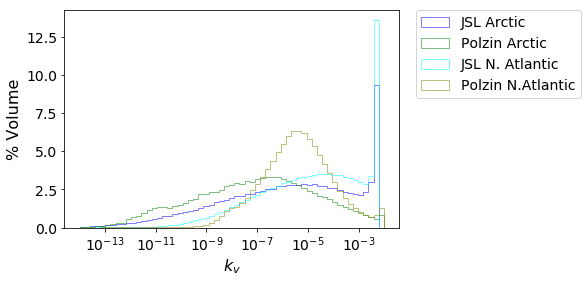

In [22]:
datalist = [sjtidal_new[:,400:,:], ptidal_new[:,400:,:],sjtidal_new[:,:400,:],
            ptidal_new[:,:400,:]]
binning = np.logspace(-14,-2,60)
dataweight = [volumeArctic,volumeArctic,volumeAtl,volumeAtl]
labeling = ['jslarctic','polzinarctic','jslatl','polzinatl']
colors = ['blue','green','cyan','olive']
legendlabels = ['JSL Arctic','Polzin Arctic','JSL N. Atlantic','Polzin N.Atlantic']
plot_histo(datalist, binning, dataweight, labeling, colors,legendlabels)

In [23]:
# #kappa for the arctic region
# #cgridW.variables
# values,bins, _ = plt.hist(sjtidal_new[:,400:,:].flatten(),bins=np.logspace(-14, -2, 60),histtype='step',
#          weights = volume2[:,:,:].flatten(),label='slj',color='blue')
# values1, bins1, _ = plt.hist(ptidal_new[:,400:,:].flatten(),bins=np.logspace(-14, -2, 60),histtype='step',
#          weights = volume2[:,:,:].flatten(),label='polzin',color='green')

# plt.gca().set_xscale('log')
# # plt.title('Histogram Kappa tidal 0-100m depth (0-23) 2011-01-05')
# plt.legend([ 'Jayne and St Laurent', 'Polzin'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=14)
# #plt.legend(loc='best')
# plt.ylabel('% Volume',fontsize=16)
# plt.xlabel('$K_v$',fontsize=16)
# plt.tick_params(axis='both',which='major',labelsize=14)
# plt.show()

In [25]:
#np.sum(values)

In [26]:
# area = np.sum(((np.diff(bins)))*values)
# print(area)
# len_bins= len(bins)-1
# total = sum(values[0:len_bins])/sum(values)
# print(total)

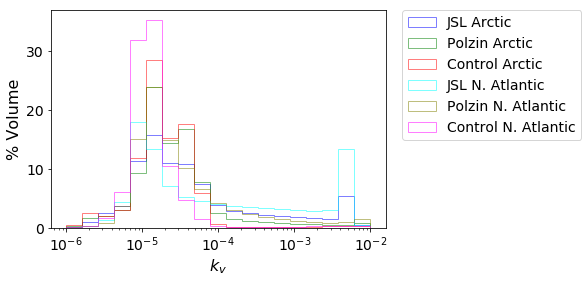

In [31]:
datalist = [sjkappa_new[:,400:,:], pkappa_new[:,400:,:],ckappa_new[:,400:,:,],
           sjkappa_new[:,:400,:], pkappa_new[:,:400,:],ckappa_new[:,:400,:,]]
binning = np.logspace(-6,-2,20)
dataweight = [volumeArctic,volumeArctic,volumeArctic,volumeAtl, volumeAtl, volumeAtl]
labeling = ['jslarctic','polzinarctic','controlArctic','jslatl',
            'polzinatl','controlatl']
colors = ['blue','green','red','cyan','olive','fuchsia']
legendlabels = ['JSL Arctic','Polzin Arctic','Control Arctic',
                'JSL N. Atlantic','Polzin N. Atlantic','Control N. Atlantic']
plot_histo(datalist, binning, dataweight, labeling, colors,legendlabels)

In [41]:
# # plt.hist([pkappa_new.flatten(),ckappa_new.flatten()],histtype='step',log=True,bins=np.logspace(-6, -2, 40),
# #          alpha=0.5,weights = [volume.flatten(),volume.flatten()],label='control')
# n = plt.hist(sjkappa_new[:,400:,:].flatten(),bins=np.logspace(-6, -2, 20),stacked=True,histtype='step',alpha=0.5,
#          label='slj',weights = volume2.flatten(),color='blue')
# values, bins, _ = plt.hist(pkappa_new[:,400:,:].flatten(),alpha=0.5,bins=np.logspace(-6, -2, 20),histtype='step',
#          label='polzin',weights = volume2.flatten(),color='green')
# values1, bins1,_ = plt.hist(ckappa_new[:,400:,:].flatten(),alpha=0.5,bins=np.logspace(-6, -2, 20),histtype='step',
#          label='control',weights = volume2.flatten(),color='red')
# plt.gca().set_xscale("log")
# # To plot correct percentages in the y axis     
# # to_percentage = lambda y, pos: str(round( ( y / float(len(data)) ) * 100.0, 2)) + '%'
# # plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percentage))
# # plt.title('Histogram Kappa 2011-01-05')
# plt.legend([ 'Jayne and St Laurent', 'Polzin','Control'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=14)
# plt.ylabel('% Volume',fontsize=16)
# plt.xlabel('$K_v$',fontsize=16)
# plt.tick_params(axis='both',which='major',labelsize=14)
# plt.show()

In [47]:
lev = 40
lati = 400

print('Median Values. Control:',np.ma.median(ckappa_mask[lev:,:lati,:]),'SLJ:',np.ma.median(sjkappa_mask[lev:,:lati,:]),
      'Polzin:',np.ma.median(pkappa_mask[lev:,:lati,:]))

Median Values. Control: 1.39666702823e-05 SLJ: 0.000158832174766 Polzin: 2.92916649557e-05


In [48]:
print('Geometric Mean Values. Control:',scstat.gmean(ckappa_mask[lev:,:lati,:],axis=None),'SLJ:',scstat.gmean(sjkappa_mask[lev:,:lati,:],axis=None),
      'Polzin:',scstat.gmean(pkappa_mask[lev:,:lati,:],axis=None))

Geometric Mean Values. Control: 1.67854715415e-05 SLJ: 0.000217384798016 Polzin: 5.0082431185e-05


In [49]:
print('Average Values. Control:',np.mean(ckappa_mask[lev:,:lati,:]),'SLJ:',np.mean(sjkappa_mask[lev:,:lati,:]),
      'Polzin:',np.mean(pkappa_mask[lev:,:lati,:]))

Average Values. Control: 5.51480987593e-05 SLJ: 0.00137363413863 Polzin: 0.000329579353202


In [39]:
print('Standard Deviation. Control:',np.std(ckappa_mask[lev:,:lati,:]),'SLJ:',np.std(sjkappa_mask[lev:,:lati,:]),
      'Polzin:',np.std(pkappa_mask[lev:,:lati,:]))

Standard Deviation. Control: 0.000954684231241 SLJ: 0.00145936981686 Polzin: 0.00109801665418


In [29]:
print('Median Values. SLJ:',np.ma.median(sjtidal_new),
      'Polzin:',np.ma.median(ptidal_new))

print('Average Values. SLJ:',np.mean(sjtidal_new),
      'Polzin:',np.mean(ptidal_new))

print('Standard Deviation. SLJ:',np.std(sjtidal_new),
      'Polzin:',np.std(ptidal_new))

Median Values. SLJ: 2.85711808459e-05 Polzin: 7.65232820306e-07
Average Values. SLJ: 0.00128965025671 Polzin: 0.000351297835253
Standard Deviation. SLJ: 0.00203598116245 Polzin: 0.00123966353725


In [42]:
# a = np.array((0.0,1.0,1.0,1.0,0.0,10))
# b = np.array((0.25,0.25,0.25,0.25,0.0,0.0))
# test_mask= np.array((0,0,0,0,1,1))
# p = np.ma.masked_where(a[:]==0.0, a)
# sj_mask = ma.getmask(p)

# b_zero = ma.array(b, mask = test_mask)
# print(b_zero)

In [43]:
# #linear case
# a = np.array((1,2,3,4))
# vol = np.array((0.25,0.25,0.25,0.25))
# bin_edges = [0.3,1.3,2.44,3.7,5]
# values, bins, _ = plt.hist(a,alpha=0.5,bins=bin_edges,histtype='step',
#          label='polzin',weights=vol)
# #lt.gca().set_xscale("log")
# plt.show()

In [44]:
# #log case
# b = np.array((0.02,0.022,0.002,0.0022))
# vol = np.array((0.25,0.25,0.25,0.25))
# bin_edges2 = [0.0002,0.001,0.002,0.02,0.2]
# values, bins, _ = plt.hist(b,alpha=0.5,bins=bin_edges2,histtype='step',
#          label='polzin',weights=vol)
# plt.gca().set_xscale("log")
# plt.show()

[1.0 -- -- --]


In [296]:
# area = np.sum(((np.diff(bins)))*values)
# print(area)

1.175


In [292]:
# print(bins, values)

[ 0.0002  0.001   0.002   0.02    0.2   ] [ 0.   0.   0.5  0.5]


In [293]:
# np.diff(bins)

array([ 0.0008,  0.001 ,  0.018 ,  0.18  ])